<a href="https://colab.research.google.com/github/Ali22017684/flower_category/blob/main/notebooks/image_notebook/logestic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [156]:
%cd flower_category

[Errno 2] No such file or directory: 'flower_category'
/content


In [157]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Imports**

In [158]:
import pandas as pd
import os
import scipy.io
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import tensorflow as tf
import cv2
from skimage import color
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score

**Constans**

In [159]:
IMG_DIR = "/content/drive/MyDrive/Dataset/102flowers/jpg"
LABELS_FILE = "/content/drive/MyDrive/Dataset/imagelabels.mat"
IMG_SIZE = (128, 128)
TEST_SIZE = 0.2
CHOOSEN_CLASSES = [1, 47, 69, 88, 97]
NUM_IMAGES = 8189

**Feature Extraction Methode**

In [160]:
def extract_hog_features(img_array):
    img = cv2.resize(img_array, (128, 128))
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    features, hog_image = hog(
        gray,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        visualize= True,
        block_norm='L2-Hys'
    )
    return features

**Phase 1**

 **Dataset Selection & Preparation**









---


1.1 Filtering Selected Spicies from the Dataset

In [161]:
def get_filtered_image_paths():
    labels = loadmat(LABELS_FILE)["labels"][0]

    all_image_paths = [
        os.path.join(IMG_DIR, f'image_0{i+1:04d}.jpg')
        for i in range(NUM_IMAGES)
    ]

    indices = [i for i, label in enumerate(labels) if label in CHOOSEN_CLASSES]

    filtered_paths = np.array(all_image_paths)[indices]
    filtered_labels = labels[indices]

    return filtered_paths, filtered_labels

1.2 Checking for Errors

In [162]:
def process_and_save_data():
    print("1. Loading Labels...")
    if not os.path.exists(LABELS_FILE):
        print("Error: imagelabels.mat not found!")
        return

1.4 Fetching and Sorting Filtered Images and Labels

In [163]:
image_files, labels = get_filtered_image_paths()

print(f"2. Processing {len(image_files)} images (Resizing to {IMG_SIZE})...")

data = []
valid_labels = []
img_features = []

2. Processing 381 images (Resizing to (128, 128))...


**Phase 2**



**Data Preproccessing and Feature Extraction**










---

2.1 Cheking the Files and Resizing the Images

In [164]:
for i, file_name in enumerate(image_files):
    try:
        img_path = os.path.join(IMG_DIR, file_name)

        img = Image.open(img_path).convert("RGB")
        img = img.resize(IMG_SIZE)
        img_array = np.array(img)

        if img_array.ndim == 3 and img_array.shape[2] == 3:
            features = extract_hog_features(img_array)
            data.append(features)
            valid_labels.append(labels[i])

        else:
            print(f"Skipping non RGB image: {file_name}")

    except Exception as e:
        print(f"Skipping error image {file_name}: {e}")

2.2 Storing data into NumPy Array and Adjusting data to the traning phase

In [165]:
X = np.array(data)
y = np.array(valid_labels)
fatures = np.array(features)

features = X.astype('float32')
#features = features / 255.0

print(features.shape)
label_map = {c: i for i, c in enumerate(CHOOSEN_CLASSES)}
y = np.array([label_map[l] for l in y])

feature_train, feature_test, y_train, y_test = train_test_split(
    features, y, test_size=TEST_SIZE, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(feature_train)
X_test_scaled = scaler.transform(feature_test)

pca = PCA(n_components=150)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)



(381, 8100)


**Phase 4**



**Logestic Regression**

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.8181818181818182


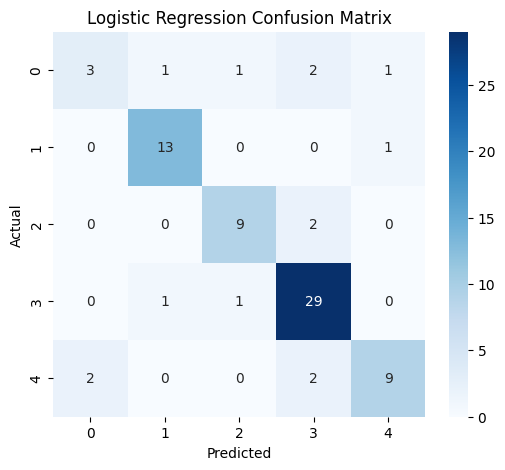

In [166]:
logreg = LogisticRegression(
    max_iter=3000,
    solver='lbfgs',
    multi_class='multinomial'
)

logreg.fit(X_train_pca, y_train)
y_pred = logreg.predict(X_test_pca)
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy:", accuracy)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression Confusion Matrix")
plt.show()


--- Copy these numbers to your documentation ---
Total Samples (Selected Classes): 381
Training Samples: 304
Testing Samples: 77

Class Distribution:
Class 1: 40 images
Class 47: 67 images
Class 69: 54 images
Class 88: 154 images
Class 97: 66 images
------------------------------------------------


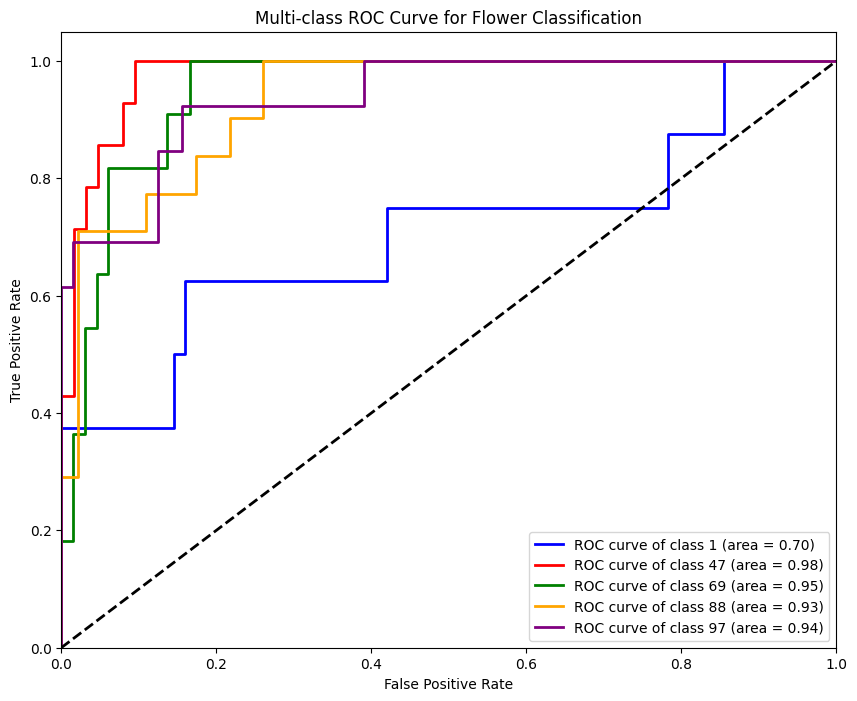

In [169]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

print("--- Copy these numbers to your documentation ---")
unique, counts = np.unique(y, return_counts=True)
print(f"Total Samples (Selected Classes): {len(y)}")
print(f"Training Samples: {len(y_train)}")
print(f"Testing Samples: {len(y_test)}")
print("\nClass Distribution:")
for label, count in zip(unique, counts):
    print(f"Class {CHOOSEN_CLASSES[label]}: {count} images")
print("------------------------------------------------")
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
n_classes = y_test_bin.shape[1]

y_score = logreg.decision_function(X_test_pca)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
real_class_names = CHOOSEN_CLASSES

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(real_class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve for Flower Classification')
plt.legend(loc="lower right")
plt.show()